In [1]:
import sys
sys.path.append("/home/hugo/projetos-doutorado/Appliance-Energy-Prediction")
import pandas as pd
from pca_fts.PcaWeightedMVFTS import PcaWeightedMVFTS
from pyFTS.benchmarks import Measures
import matplotlib.pyplot as plt
from pyFTS.common import Util
import datetime
import statistics
import math
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

## Aux functions

In [2]:
def sample_first_prows(data, perc=0.75):
    return data.head(int(len(data)*(perc)))

In [3]:
# convert series to supervised learning
def series_to_supervised_miso(data, n_in, n_out, endog_var='Global_active_power', dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [(df.columns[j]+'(t-%d)' % (i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df[endog_var].shift(-i))
		if i == 0:
			names += [(endog_var+'(t)')]
		else:
			names += [(endog_var+'(t+%d)' % (i))]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [4]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame) 
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

## Dataset Energy Appliance

In [5]:
filepath = '/home/hugo/projetos-doutorado/Appliance-Energy-Prediction/data/household_power_consumption.csv'
data = pd.read_csv(filepath, sep = ";")
data = data.drop(labels=['Time','Date'], axis=1)
data.dropna(inplace = True)
data = clean_dataset(data)
data.head()


/home/hugo/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [6]:
data['Global_active_power'] = pd.to_numeric(data['Global_active_power'],errors='coerce')
data['Global_reactive_power'] = pd.to_numeric(data['Global_reactive_power'],errors='coerce')
data['Voltage'] = pd.to_numeric(data['Voltage'],errors='coerce')
data['Global_intensity'] = pd.to_numeric(data['Global_intensity'],errors='coerce')
data['Sub_metering_1'] = pd.to_numeric(data['Sub_metering_1'],errors='coerce')
data['Sub_metering_2'] = pd.to_numeric(data['Sub_metering_2'],errors='coerce')
data['Sub_metering_3'] = pd.to_numeric(data['Sub_metering_3'],errors='coerce')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2049280 entries, 0 to 2075258
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 125.1 MB


### Dataset Household: columns

### Dataset Household: Preprocessing, Lag = 1, t+1

In [7]:
# frame as supervised learning
data = series_to_supervised_miso(data, 1, 1,endog_var='Global_active_power')
data.head()

,Global_active_power(t-1),Global_reactive_power(t-1),Voltage(t-1),Global_intensity(t-1),Sub_metering_1(t-1),Sub_metering_2(t-1),Sub_metering_3(t-1),Global_active_power(t)
1,4.216,0.418,234.84,18.4,0.0,1.0,17.0,5.360
2,5.360,0.436,233.63,23.0,0.0,1.0,16.0,5.374
3,5.374,0.498,233.29,23.0,0.0,2.0,17.0,5.388
4,5.388,0.502,233.74,23.0,0.0,1.0,17.0,3.666
5,3.666,0.528,235.68,15.8,0.0,1.0,17.0,3.520


## Model: PcaWeightedMVFTS - PCA-MVFTS

In [8]:
pca_wmvfts = PcaWeightedMVFTS(n_components = 3,
                       endogen_variable = 'Global_active_power(t-1)',
                       n_part = 50)

/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


--------------------
training window 0
[ 18:44:06] getting statistics
Results: (0.08397981654477331, 0.032425644412407174, 3.0427714432349497, 1.4082349554425075)


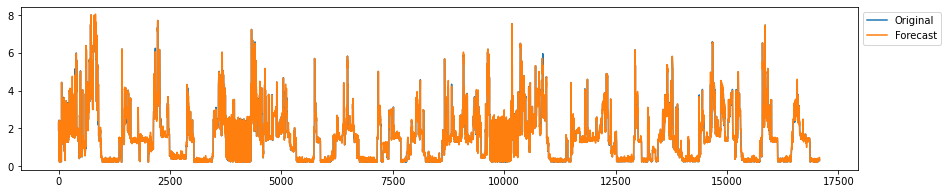

--------------------
training window 68309


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[ 18:46:07] getting statistics
Results: (0.0915341366909434, 0.034539397961708226, 1.7864095727884917, 0.8793204222791454)


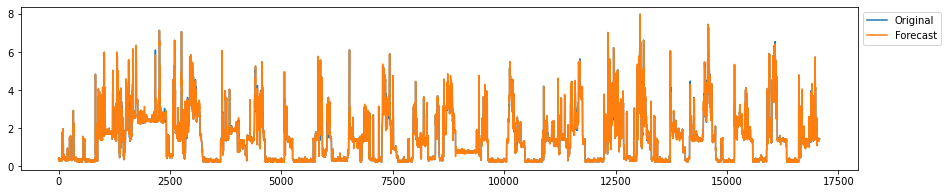

--------------------
training window 136618


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[ 18:48:02] getting statistics
Results: (0.13906559623582931, 0.040785719978037, 7.421361592867759, 3.067861718639925)


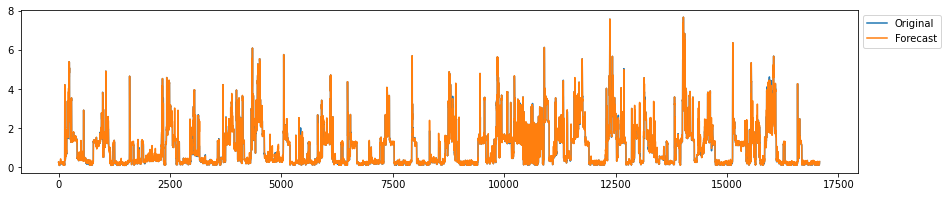

--------------------
training window 204927


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[ 18:49:49] getting statistics
Results: (0.04715611552276616, 0.011026051999268743, 2.993297023229292, 1.296829485230342)


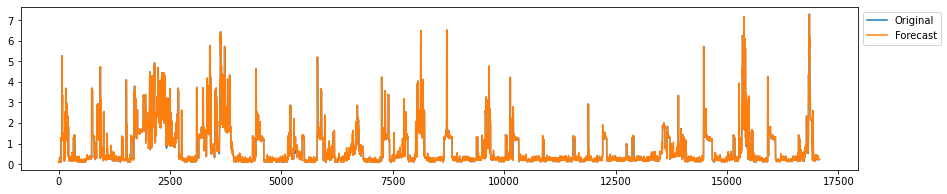

--------------------
training window 273236


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[ 18:51:32] getting statistics
Results: (0.05347563361124792, 0.009463628256335043, 0.7572781066371899, 0.4370352079518281)


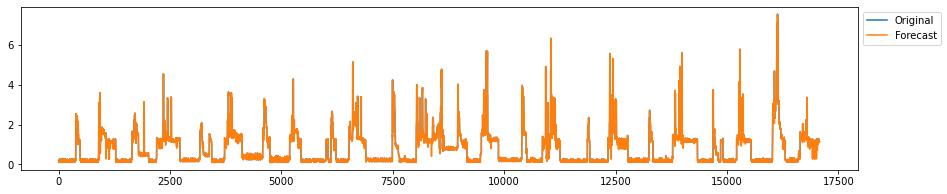

--------------------
training window 341545


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[ 18:53:24] getting statistics
Results: (0.06560736011456658, 0.018700644973325905, 2.2857387871136026, 1.0966596583490733)


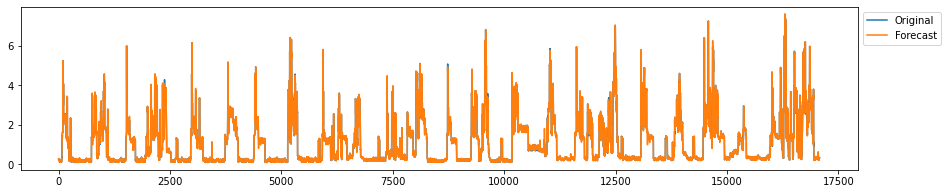

--------------------
training window 409854


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[ 18:55:08] getting statistics
Results: (0.04102241740586046, 0.008043272361660237, 0.5439632360059059, 0.2962215481288786)


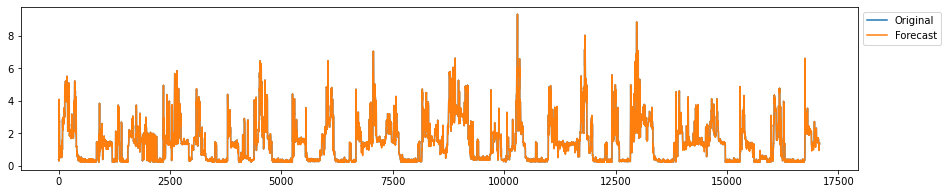

--------------------
training window 478163


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[ 18:57:04] getting statistics
Results: (0.08176601612518707, 0.030349916283685347, 2.2933403306722453, 1.2247859221187913)


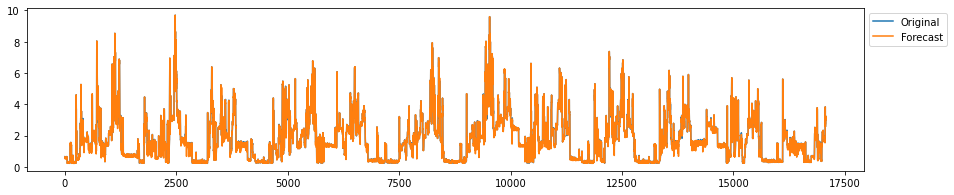

--------------------
training window 546472


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[ 18:58:52] getting statistics
Results: (0.09962141102164128, 0.0350583512069741, 4.564929664941791, 2.072447370978975)


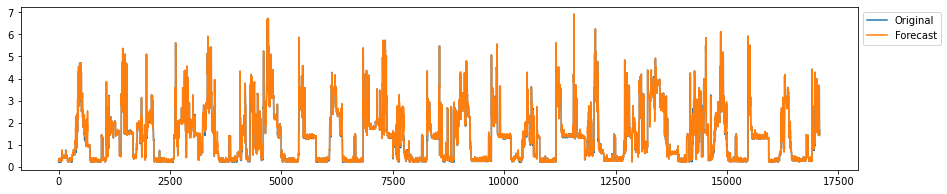

--------------------
training window 614781


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[ 19:00:38] getting statistics
Results: (0.04612116951390733, 0.018622838937451692, 4.92615570549434, 2.226086100744216)


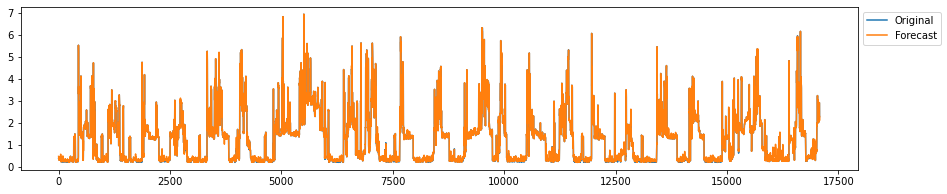

--------------------
training window 683090


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[ 19:02:33] getting statistics
Results: (0.08210083518828075, 0.046163692089653784, 11.392614770279978, 4.814034398001033)


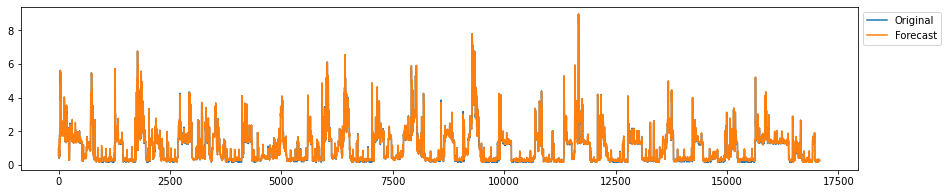

--------------------
training window 751399


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[ 19:04:17] getting statistics
Results: (0.08595320661093313, 0.043621816385624124, 13.347496657124502, 5.286638505016138)


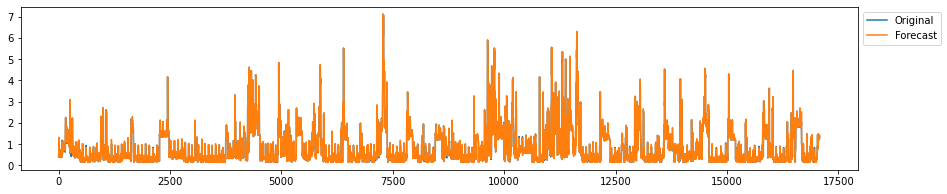

--------------------
training window 819708


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[ 19:05:56] getting statistics
Results: (0.014992648483260726, 0.004998818398895124, 3.368079922139955, 1.448792117644457)


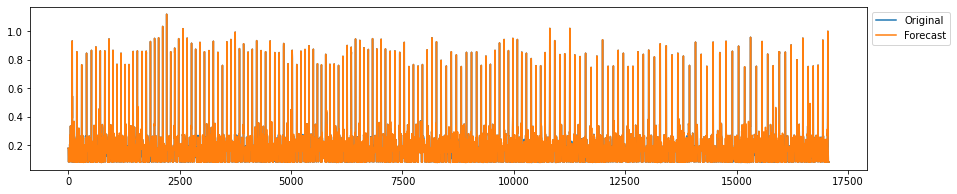

--------------------
training window 888017


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[ 19:07:43] getting statistics
Results: (0.07240003899601012, 0.025542770980673445, 3.122605128724103, 1.5339875511269903)


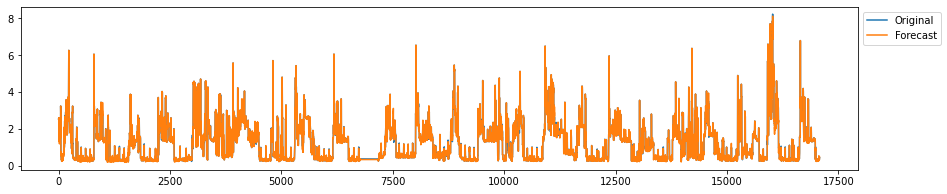

--------------------
training window 956326


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[ 19:09:15] getting statistics
Results: (0.04516508381397596, 0.011003615362929183, 0.5980653518327249, 0.2897926433967166)


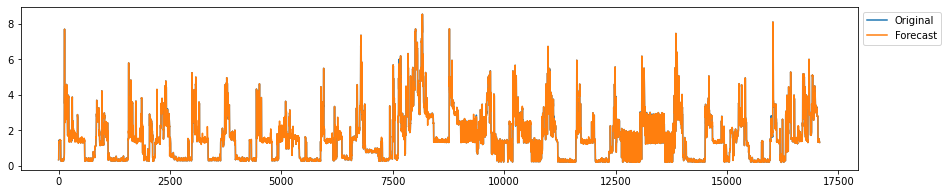

--------------------
training window 1024635


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[ 19:10:56] getting statistics
Results: (0.08173231430617683, 0.024564676741431146, 1.4337099834305223, 0.6900211440794751)


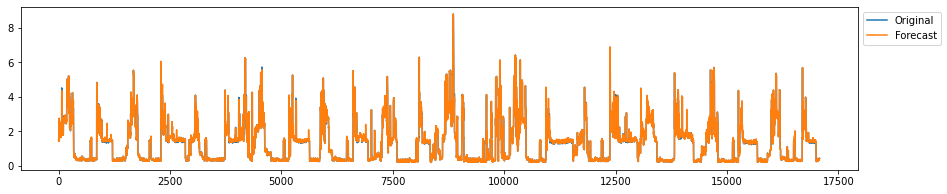

--------------------
training window 1092944


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[ 19:12:42] getting statistics
Results: (0.10096923039616476, 0.0392371229577774, 7.000126857937531, 2.7308931956873477)


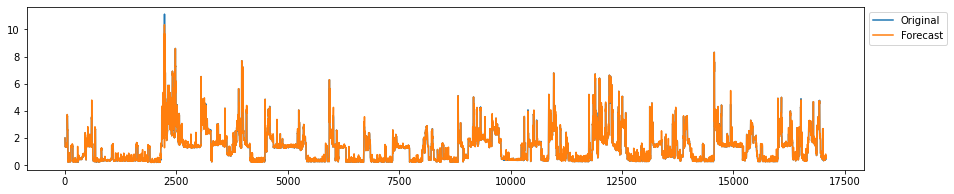

--------------------
training window 1161253


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[ 19:14:33] getting statistics
Results: (0.07984631013334659, 0.02812189819500884, 3.645435263018283, 1.7043896950561397)


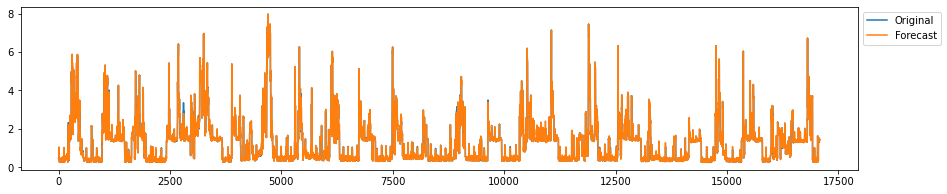

--------------------
training window 1229562


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[ 19:16:31] getting statistics
Results: (0.08261399437384456, 0.037644390743297805, 10.599179905925666, 4.169636037117356)


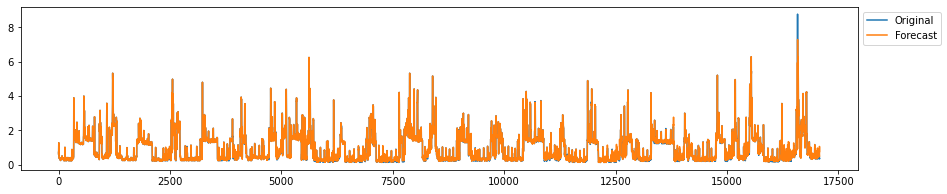

--------------------
training window 1297871


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[ 19:18:10] getting statistics
Results: (0.006404119793705302, 0.000527777038499483, 0.06614813240928202, 0.03377188400677594)


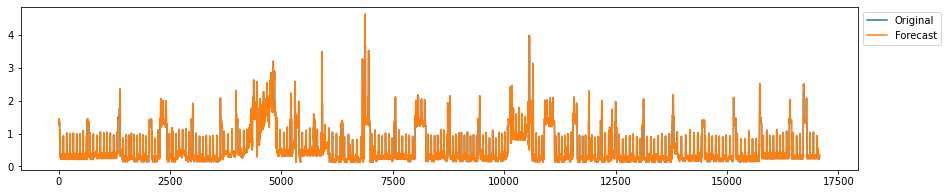

--------------------
training window 1366180


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[ 19:19:56] getting statistics
Results: (0.05319324010250855, 0.015617750350791845, 2.059455251151226, 1.000833198589283)


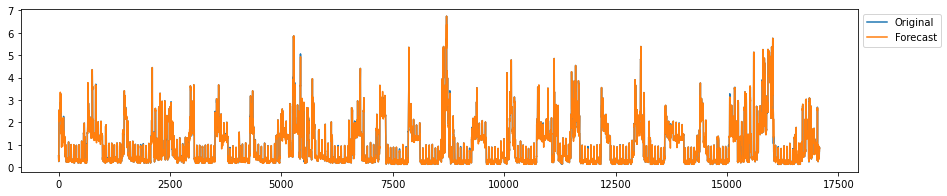

--------------------
training window 1434489


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[ 19:21:58] getting statistics
Results: (0.10307544954273992, 0.04286306211160767, 6.43631825094813, 2.7969132868046365)


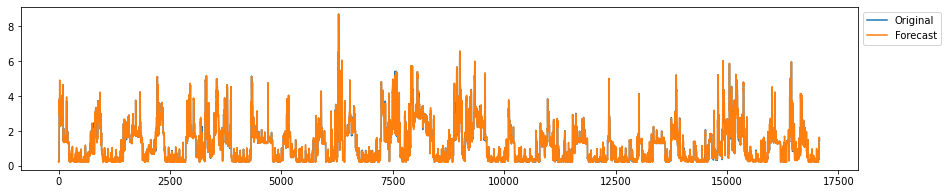

--------------------
training window 1502798


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[ 19:23:52] getting statistics
Results: (0.10237864733958783, 0.03238445388393432, 3.5314261063294454, 1.5727690235961422)


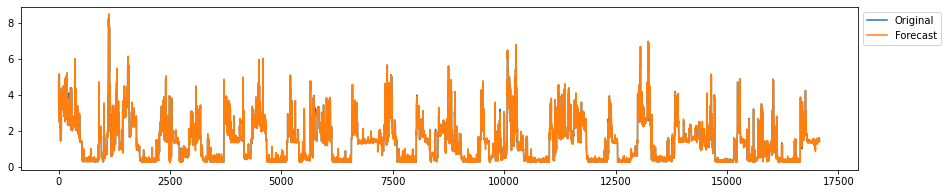

--------------------
training window 1571107


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[ 19:25:31] getting statistics
Results: (0.06636814886732312, 0.014056540325502178, 0.9231977078942448, 0.5190096409724237)


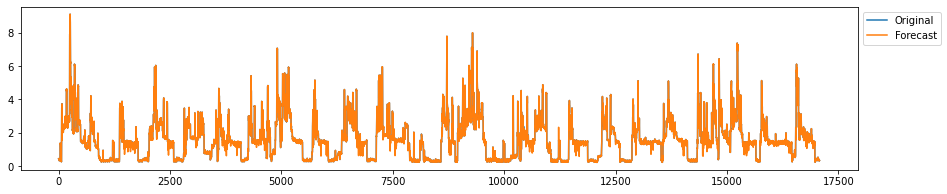

--------------------
training window 1639416


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[ 19:27:26] getting statistics
Results: (0.06356757831181178, 0.021771224943482964, 2.370526138686344, 1.1465079263176337)


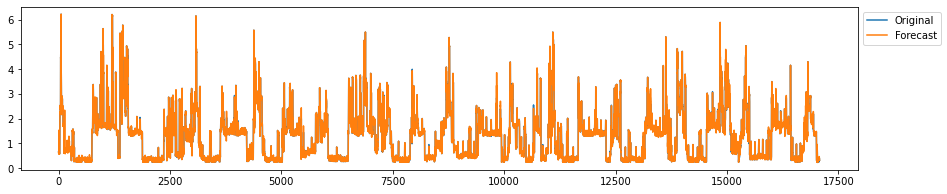

--------------------
training window 1707725


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[ 19:29:24] getting statistics
Results: (0.059929553179744764, 0.02505643678176218, 4.069811712157227, 1.888961269835968)


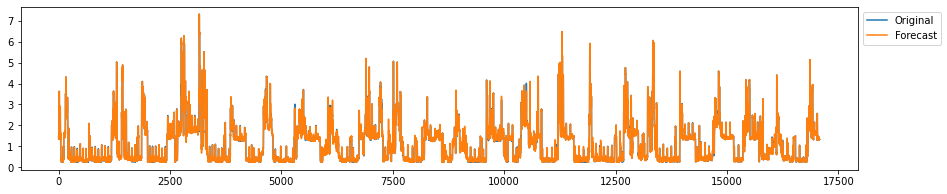

--------------------
training window 1776034


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[ 19:31:19] getting statistics
Results: (0.08179248064362961, 0.04329818246599041, 10.38988931560248, 4.444284918986472)


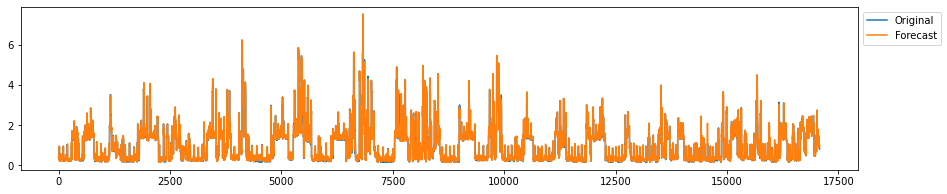

--------------------
training window 1844343


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[ 19:33:06] getting statistics
Results: (0.007218735764779887, 0.002044415452760504, 0.8001614166012633, 0.4033628274198917)


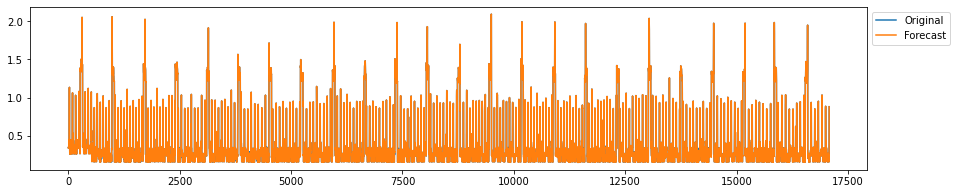

--------------------
training window 1912652


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[ 19:35:22] getting statistics
Results: (0.06817758598978009, 0.02559388297588615, 3.9401984793412828, 1.8357711661340073)


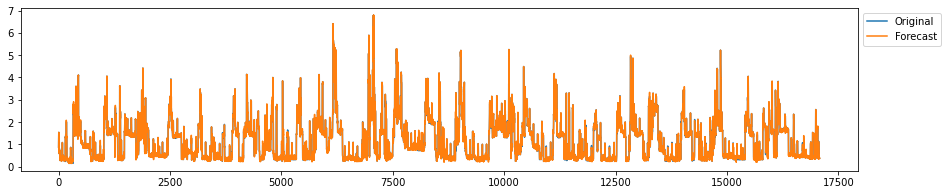

/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


--------------------
training window 1980961
[ 19:38:01] getting statistics
Results: (0.01055601804993468, 0.003890927667440281, 0.09545055195780379, 0.04769004035842378)


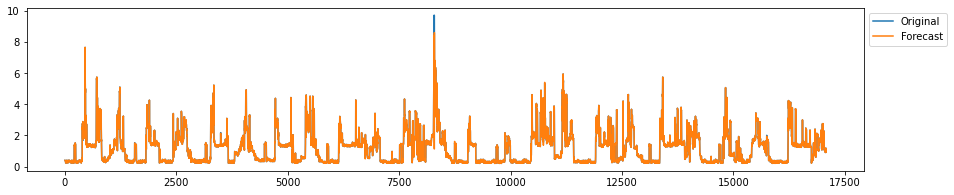

In [9]:
result = {
     "window": [],
     "rmse": [],
     "mae": [],
     "mape": [],
     "smape": []
}

tam = len(data)
n_windows = 30
windows_length = math.floor(tam / n_windows)
for ct, ttrain, ttest in Util.sliding_window(data, windows_length, 0.75, inc=1):
    if len(ttest) > 0:
        
        data_train = ttrain.loc[:,'Global_active_power(t-1)':'Sub_metering_3(t-1)']
        data_test = ttest.loc[:,'Global_reactive_power(t-1)':'Global_active_power(t)']
         
        #ALtera o nome da columa porque o modelo utiliza esse label como variável endogena 
        data_test.rename(columns = {'Global_active_power(t)': 'Global_active_power(t-1)'}, inplace = True)
        
        print('-' * 20)
        print(f'training window {(ct)}')
        model, pca_reduced_train = pca_wmvfts.run_train_model(data_train)
        forecast, forecast_self, pca_reduced_test = pca_wmvfts.run_test_model(model,data_test)
        
        print("[{0: %H:%M:%S}]".format(datetime.datetime.now()) + f" getting statistics")
        
        #Teste e cálculo dos erros da previsão  
        #valor use Global_reactive_power(t-1) é o Global_reactive_power(t) --> label igual por causa do modelo 
        rmse = Measures.rmse(pca_reduced_test['Global_active_power(t-1)'],forecast)
        mape = Measures.mape(pca_reduced_test['Global_active_power(t-1)'],forecast)
        smape = Measures.smape(pca_reduced_test['Global_active_power(t-1)'],forecast)
        
        forecast = pd.DataFrame(forecast)
        forecast.fillna(forecast.mean(),inplace=True)
        forecast = np.array(forecast).reshape(-1)
        mae = mean_absolute_error(pca_reduced_test['Global_active_power(t-1)'], forecast)
        
        print(f'Results: {(rmse,mae,mape,smape)}')
        
        # Grafico de comparação Original x Previsto para cada janela
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15, 3])
        ax.plot(pca_reduced_test['Global_active_power(t-1)'], label='Original')
        ax.plot(forecast, label='Forecast')
        handles, labels = ax.get_legend_handles_labels()
        lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))
        plt.show()
        
        result["rmse"].append(round(rmse,3))
        result["mape"].append(round(mape,3))
        result["smape"].append(round(smape,3))
        result["mae"].append(round(mae,3))
        result["window"].append(ct)
        
measures = pd.DataFrame(result)



In [25]:
measures

,window,rmse,mae,mape,smape
0,0,0.084,0.032,3.043,1.408
1,68309,0.092,0.035,1.786,0.879
2,136618,0.139,0.041,7.421,3.068
3,204927,0.047,0.011,2.993,1.297
4,273236,0.053,0.009,0.757,0.437
5,341545,0.066,0.019,2.286,1.097
6,409854,0.041,0.008,0.544,0.296
7,478163,0.082,0.030,2.293,1.225
8,546472,0.100,0.035,4.565,2.072
9,614781,0.046,0.019,4.926,2.226


### Mean Statistics PCA-WMVFTS:

In [24]:
final_result = {
     "rmse": [],
     "mae": [],
     "mape": [],
     "smape": []
}

final_result["rmse"].append(round(statistics.mean(measures['rmse']),3))
final_result["mae"].append(round(statistics.mean(measures['mae']),3))
final_result["mape"].append(round(statistics.mean(measures['mape']),3))
final_result["smape"].append(round(statistics.mean(measures['smape']),3))

        
final_measures_pca = pd.DataFrame(final_result)

print("Mean Statistics PCA-WMVFTS (test): ")
final_measures_pca

Mean Statistics PCA-WMVFTS (test): 


,rmse,mae,mape,smape
0,0.067,0.024,3.993,1.746


### Extras 

In [12]:
# pca_reduced_test

In [13]:
# print(model)

In [14]:
# train = sample_first_prows(data,0.75)
# test = data.iloc[max(train.index):]
# y_test = data.iloc[max(train.index):]['Appliances_t+1'].values

In [15]:
# pca_wmvfts = PcaWeightedMVFTS(n_components = 2,
#                        endogen_variable = 'Appliances_t+1',
#                        n_part = 50)

In [16]:
# model, pca_reduced_train = pca_wmvfts.run_train_model(train)
# forecast, forecast_self, pca_reduced_test = pca_wmvfts.run_test_model(model,test)

In [17]:
#model.mvflrg

In [18]:
# forecast_1 = model.predict(pca_reduced_test)

In [19]:
# Measures.rmse(y_test,forecast)

In [20]:
# Measures.rmse(forecast_1,y_test)

In [21]:
# Measures.rmse(y_test,forecast_self)

In [22]:
# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15, 3])
# ax.plot(y_test, label='Original')
# ax.plot(forecast, label='Forecast')
# handles, labels = ax.get_legend_handles_labels()
# lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))
# plt.show()


In [23]:
# diff = data.loc[:,'lights':'Tdewpoint']
# diff = diff.diff()
# diff['Appliances'] = data['Appliances']
# data = diff.dropna()